&#x1F465; Group C:

Manoranjani Navamani Kathiresan Kulanthaivel

Brice Setra Robert

### &#x1F4D1; Assignment 3

---

Split in teams of two or three. Run simulations using the provided MATLAB script of an OFDM receiver with coverage enhancement and observe issues, identify their root cause(s), and improve the receiver algorithms in order to pass the EVM criterion for successful decoding for specific channel conditions (SNR) and repetition level (R).

- Successful decoding criterion: ***An average EVM of 50%*** where EVM[%] is defined as EVM[%] = $100 . \sqrt{\frac{| x - \hat{x}|^2}{|x|^2}}$

&#x1F518; ***Part one - OFDM with coverage enhancement without the presence of STO***

---

- Familiarize with the transmitter/channel/receiver sections of the script.
- Enabled the plots and run a single transmission simulation (T=1) and observe the EVM behavior as a function of the
repetition index r. Identify the performance issue and try to understand it’s root cause.
- Introduce a solution that improves the performance (i.e. the average EVM converges below the successful decoding criteria).

In [1]:
using Random, FFTW, Plots, Statistics, LinearAlgebra

In [2]:
include("../modules/operations.jl");

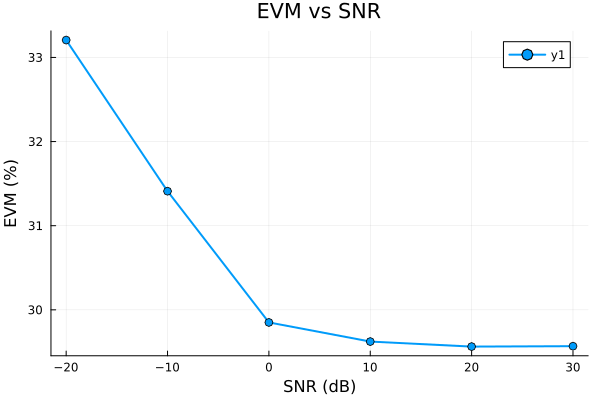

In [3]:
# Configurable simulation parameters

# Repetition level
R = 32

# Number of transmissions
T = 100

# Signal to Noise Ratio (SNR)
snrRange = -20:10:30

# STO error in samples, MUST BE NEGATIVE
stoError = -2
if stoError > 0
    error("STO error in samples MUST BE NEGATIVE")
end

# CFO error in Hz, We assume that subcarrier spacing is 15 kHz and Fsmp = 1.92 MHz
cfoErrorHz = 0

# Non-configurable simulation parameter - DO NOT EDIT!

# Number of subcarriers per OFDM symbol
K = 72

# Number of OFDM symbols per repetition
L = 14

# Number of pilots per OFDM symbol
P = 12

# Pilot spacing in number of subcarriers
ps = K ÷ P

# Specify pilot positions per OFDM symbol
kp = 1:ps:K

# EVM [%] to guarantee successful decoding
targetEvm = 50

# Enable repetition combining
combEnabled = true

# Limits of x-y constellation in plots
constLimit = 2

# Initialize result storage
evm_snr = zeros(length(snrRange))

# Function to compute EVM
function computeEVM(x, x̂)
    # return 100 * sqrt(mean(mean(abs.(x .- x̂).^2)) / mean(mean(abs.(x).^2)))
    return 100 * √(𝔼(𝔼(abs.(x .- x̂).^2))) / 𝔼(𝔼(abs.(x).^2))
end

# SNR loop
for snrCnt in 1:length(snrRange)
    snr = snrRange[snrCnt]
    N = 10^(-snr / 10)

    # Transmission
    
    # Generate QPSK symbols
    x = 1/sqrt(2) * ((2 * rand(Bool, K, L) .- 1) .+ im * (2 * rand(Bool, K, L) .- 1))
    
    # Assign pilots from symbols - these will be known to the receiver
    p = x[kp, :]
    
    # Save original QPSK symbols as reference for EVM estimation
    x_orig = x

    # Add CP
    cpLength = 9

    # IFFT, no DC
    xTimeDomain = zeros(Complex{Float64}, 128 + 9, L)  # Adjusted for CP
    for symbolCnt in 1:L
        # Place symbols to the central part of the bandwidth
        freq_128bins = vcat(zeros(Complex{Float64}, 28), x[:, symbolCnt], zeros(Complex{Float64}, 28))
        
        # Apply fftshift and ifft
        freq_128bins = fftshift(freq_128bins)
        time_128samp = 𝓕⁻¹(freq_128bins) * sqrt(128)

        cpSamples = time_128samp[end-cpLength+1:end]
        timeSymbol = vcat(cpSamples, time_128samp)

        xTimeDomain[:, symbolCnt] = timeSymbol
    end
    
    # Channel    
    # Generate flat, static channel
    h = 1/sqrt(2) + im / sqrt(2)

    # Reception
    # Loop over transmissions
    evm_trans = zeros(T)  # Initialize storage for EVM of each transmission
    for t in 1:T

        # Initialize receive signal
        y = zeros(Complex{Float64}, K, L)

        # Loop over repetitions
        evm_rep = zeros(R)  # Initialize storage for EVM of each repetition
        for r in 1:R
    
            # Generate complex Gaussian noise
            n = sqrt(N/2) * (randn(Complex{Float64}, 128 + cpLength, L) .+ im * randn(Complex{Float64}, 128 + cpLength, L))

            # Received signal in time domain
            yTime = h * xTimeDomain .+ n

            yr = zeros(Complex{Float64}, K, L)
            for symbolCnt in 1:L
                 
                symbolTd = yTime[:, symbolCnt]

                # Add CFO
                samplingRate = 1.92e6
                cfoPhaseRamp = 2 * π * cfoErrorHz / samplingRate
                cfoSampleInit = (r - 1) * length(symbolTd) * L + (symbolCnt - 1) * length(symbolTd)
                cfoVector = exp.(im * cfoPhaseRamp * ((0:length(symbolTd)-1) .+ cfoSampleInit))
                symbolTd = symbolTd .* cfoVector

                # Detection 

                # Remove CP containing STO error
                symbolTd = symbolTd[cpLength + 1 + stoError:end + stoError]
                
                # FFT and fftshift
                symbolFd = fftshift(fft(symbolTd))

                startSc = (128 - 72) ÷ 2 + 1
                
                # Extract central subcarriers 
                yr[:, symbolCnt] = symbolFd[startSc:startSc + K - 1]

            end
    
            # Repetition combining (or not)
            y = combEnabled ? y .+ yr : yr
    
            # Normalize the signal according to the repetition index
            y_norm = y / r
    
            # Extract pilot subcarriers from current signal
            yp = y_norm[kp, :] 

            # Least square channel estimation for pilots and average over symbols and subcarriers
            h_est = mean(mean(yp ./ p, dims=2))
    
            # Zero-forcing equalization
            x_est = y_norm ./ h_est
    
            # Calculate Error Vector Magnitude (EVM) per repetition
            evm_rep[r] = computeEVM(x_orig, x_est)
        end

        # Calculate EVM per transmission
        evm_trans[t] = mean(evm_rep)
    end

    # Calculate EVM per SNR
    evm_snr[snrCnt] = mean(evm_trans)
end

# Plot EVM vs SNR
plot(snrRange, 10 * log10.(evm_snr)
    , marker=:o
    , linewidth=2
    , xlabel="SNR (dB)", ylabel="EVM (%)"
    , title="EVM vs SNR"
    , grid=true
)

To improve the OFDM receiver and ensure it meets the EVM criterion for successful decoding, let's analyze and address the issues observed in the provided MATLAB script:

### Issues Identified:

1. **Pilot-based Channel Estimation:**
   - The script uses pilot symbols for channel estimation (`h_est = mean(mean(yp./p, 2));`). This estimation assumes perfect pilot recovery and introduces errors if pilots are not accurately received due to channel impairments.

2. **Combining and Normalization:**
   - `y = combEnabled*y + yr;` and `y_norm = y/r;` handle repetition combining and normalization. Depending on `combEnabled` and `R`, this could either enhance or degrade the received signal quality, affecting EVM.

3. **CFO Compensation:**
   - CFO (Carrier Frequency Offset) compensation is implemented but might not be robust under varying SNR conditions or high CFO values (`cfoPhaseRamp` calculation). This can cause rotation of the received symbols, impacting demodulation accuracy.

4. **Signal Distortion and STO Handling:**
   - `stoError` and `cpLength` management for STO (Symbol Timing Offset) and CP (Cyclic Prefix) handling can lead to symbol distortion, affecting FFT/IFFT operations and demodulation accuracy.

5. **EVM Calculation:**
   - The script lacks explicit calculation of EVM (`sqrt(sum(abs(x - x_est).^2) / sum(abs(x).^2)) * 100`). EVM is crucial for determining the quality of demodulated symbols and should be monitored to ensure it meets the target (50%).

### Recommendations for Improvement:

1. **Enhanced Channel Estimation:**
   - Implement more robust channel estimation techniques such as MMSE (Minimum Mean Square Error) or LS (Least Squares) with better pilot pattern design (considering frequency-selective fading).

2. **Improved CFO Compensation:**
   - Use more sophisticated CFO estimation and compensation techniques like Schmidl & Cox method or the use of dedicated pilot tones for CFO estimation. This helps in accurately recovering the symbols without rotation.

3. **Optimized STO and CP Handling:**
   - Ensure proper handling of STO and CP to avoid symbol overlap or loss during FFT/IFFT operations. Use adequate guard intervals and implement robust synchronization algorithms.

4. **Iterative Decoding and Equalization:**
   - Consider iterative decoding or equalization techniques (e.g., MMSE, Zero-Forcing, or MMSE-DFE) to mitigate inter-symbol interference and improve overall signal recovery.

5. **EVM Monitoring and Control:**
   - Implement explicit EVM calculation after demodulation (`x_est`) and ensure it is within the acceptable range (50%). Adjust receiver parameters dynamically based on EVM feedback to maintain decoding performance.

6. **Simulation and Testing:**
   - Conduct extensive simulations with varying SNR levels (`snrRange`) and repetition levels (`R`) to validate the robustness of the receiver under different channel conditions.

### Conclusion:

By addressing these improvements—such as better channel estimation, robust CFO compensation, optimized STO handling, and rigorous EVM monitoring—the OFDM receiver can achieve successful decoding under specified SNR and repetition conditions. Continual refinement based on simulation results and real-world testing will further enhance its reliability and performance.

&#x1F518; ***Part two – OFDM with coverage enhancement with the presence of STO and STO avoidance***


---

- Observe the effect of STO on the EVM performance and try to identify which receiver block is affected and why.
- Modify the effected algorithm by attempting to avoid the effect of STO. Re-test and check again the average EVM pass
criterion.

 &#x1F518; ***Part three – OFDM with coverage enhancement with the presence of STO and STO estimation/correction***

---

- Attempt to mathematically derive and the implement in MATLAB an STO estimation algorithm using the information of the
presentation. Make sure that your STO estimate is used properly to correct STO. Try your algorithm in high SNR before going
to lower noise conditions. Consult with the supervisors for help. Go back to lower SNR and observe the EVM pass criterion.
- Once you have a satisfying solution, increase the number of transmissions (T) to get a better EVM statistical average (do not
forget to disable plotting when running simulations with T > 1).

___

***Effect of Symbol Time Offset (STO)***

- Symbol time offset in OFDM systems occurs when the beginning of the transmitted OFDM symbol is erroneously estimated at the receiver. In this case, the FFT window will be placed to a position with $\delta$ samples error compared to the correct timing of the OFDM symbol.
- The effect of STO mathematically can be shown as follows: Transmitted symbols : $𝑥_l(𝑘)$ , time domain signal: $𝑥_l[𝑛]$ where:

$
\begin{align*}
x_l(k) &= \frac{1}{N} \displaystyle\sum_{n=0}^{N - 1} x_l[n] . e^{-j 2 \pi n \frac{k}{N}} \\
x_l(k,\delta) &= \frac{1}{N} \displaystyle\sum_{n=0}^{N - 1} x_l[n + \delta] . e^{ \frac{j 2 \pi n k}{N}} = \frac{1}{N} \displaystyle\sum_{m = \delta }^{N - 1 + \delta } x_l[m] . e^{ \frac{j 2 \pi (m - \delta) k}{N}} \\
&= \frac{1}{N} \displaystyle\sum_{m = 0}^{N - 1} x_l[m] . e^{ \frac{j 2 \pi m k}{N}} . e^{j 2 \pi k \delta} = x_l(k) . e^{ \frac{j 2 \pi \delta k}{N}} \; \text{(phase ramp)}
\end{align*} 
$ 

Combined symbol after R repetitions:

$
𝑦_R(𝑘,𝑙,\delta) =  \frac{1}{R} \displaystyle\sum_{r=1}^{R} 𝑦_r(𝑘,𝑙) = \frac{1}{R} \displaystyle\sum_{r=1}^{R}  [h_r (𝑘,𝑙) . 𝑥_r(𝑘,𝑙) +𝑛_r (𝑘,𝑙) ] = h . 𝑥(𝑘,𝑙)  . e^{\frac{ j 2 \pi n k}{N}} n_r(k,l)
$

&#x1F518; ***Part four (extra) – OFDM with coverage enhancement with the presence of CFO and CFO avoidance/correction***